In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_173695/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from pyDOE import lhs

import os
import time

plt.rcParams.update({'font.size':18})

In [3]:
def seed_torch(seed=1024):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#     torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch(1024)

In [4]:
domain = (-1, 1, -1, 1)
xmin, xmax, ymin, ymax = domain
mlp_layers = [2, 128, 128, 128, 128, 128, 128, 1]
Nsd = 10000
n_bcs = 128
lr=1e-3
adam_epoch = 25000
lbfgs_epoch = 1000
gamma = 0.7
step_size = 1000
newton_iter = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

## 数据集生成

In [5]:
class DatasetAC:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, Nsd, n_bcs, verbose=None):
        xmin, xmax, ymin, ymax = self.domain
        # 内部点采样
        
#         lb1 = np.array([-1., -1.])
#         ub1 = np.array([0., 0.])
#         lb2 = np.array([-1., 0.])
#         ub2 = np.array([0., 1.])
#         lb3 = np.array([0.0, -1.])
#         ub3 = np.array([1., 0.])

#         xy_res1 = (ub1-lb1)*lhs(2, int(Nsd/3))+lb1
#         xy_res2 = (ub2-lb2)*lhs(2, int(Nsd/3))+lb2
#         xy_res3 = (ub3-lb3)*lhs(2, int(Nsd/3))+lb3
        
#         X_res = np.concatenate([xy_res1, xy_res2, xy_res3], 0)

        lb = np.array([-1.0, -1.0])
        ub = np.array([1.0, 1.0])
        xy = (ub-lb)*lhs(2, Nsd)+lb
        xy = xy[~((xy[:,0]>=0) * (xy[:,1]>=0))]
        
        # 边界点采样
        
#         # 对于x
#         lb_bcs_1 = np.array([-1., -1.])
#         ub_bcs_1 = np.array([1., -1.])
#         lb_bcs_2 = np.array([-1., 1.])
#         ub_bcs_2 = np.array([0.0, 1.])
#         lb_bcs_3 = np.array([0.0, 0.0])
#         ub_bcs_3 = np.array([1., 0.0])
#         xy_bcs_1 = (ub_bcs_1-lb_bcs_1)*lhs(2, n_bcs)+lb_bcs_1
#         xy_bcs_2 = (ub_bcs_2-lb_bcs_2)*lhs(2, n_bcs)+lb_bcs_2
#         xy_bcs_3 = (ub_bcs_3-lb_bcs_3)*lhs(2, n_bcs)+lb_bcs_3
#         xy_bcs_x = np.concatenate([xy_bcs_1,xy_bcs_2,xy_bcs_3],0)
#         # 对于y
#         lb_bcs_4 = np.array([-1., -1.])
#         ub_bcs_4 = np.array([-1., 1.])
#         lb_bcs_5 = np.array([0.0, 0.0])
#         ub_bcs_5 = np.array([0.0, 1.])
#         lb_bcs_6 = np.array([1., -1.])
#         ub_bcs_6 = np.array([1., 0.0])
#         xy_bcs_4 = (ub_bcs_4-lb_bcs_4)*lhs(2, n_bcs)+lb_bcs_4
#         xy_bcs_5 = (ub_bcs_5-lb_bcs_5)*lhs(2, n_bcs)+lb_bcs_5
#         xy_bcs_6 = (ub_bcs_6-lb_bcs_6)*lhs(2, n_bcs)+lb_bcs_6
#         xy_bcs_y = np.concatenate([xy_bcs_4,xy_bcs_5,xy_bcs_6],0)
#         X_bcs = np.concatenate([xy_bcs_x,xy_bcs_y],0)


        bound_1 = lhs(1, n_bcs)-1 # -1 -> 0
        bound_1 = bound_1.reshape(-1,1)
        
        bound_2 = lhs(1, n_bcs) # 0 -> 1
        bound_2 = bound_2.reshape(-1,1)
        
        xy_b_1 = np.hstack((bound_1, bound_1*0-1))
        xy_b_2 = np.hstack((bound_2, bound_2*0-1))
        xy_b_3 = np.hstack((bound_1*0-1, bound_1))
        xy_b_4 = np.hstack((bound_1*0-1, bound_2))
        xy_b_5 = np.hstack((bound_1, bound_1*0+1))
        xy_b_6 = np.hstack((bound_2, bound_1*0))
        xy_b_7 = np.hstack((bound_1*0+1, bound_1))
        xy_b_8 = np.hstack((bound_1*0, bound_2))        
        xy_b = np.vstack([xy_b_1, xy_b_2, xy_b_3, xy_b_4, xy_b_5, xy_b_6, xy_b_7, xy_b_8])
        
        xy = torch.from_numpy(xy).float().to(device)
        xy_b = torch.from_numpy(xy_b).float().to(device)
        return xy, xy_b
    
    def sample_xy(self, x, y):
        xx, yy = np.meshgrid(x, y)
        X = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)
        return X
    

dataset = DatasetAC(domain)
X_res, X_bcs = dataset.train_data(Nsd, n_bcs)
print(X_res.shape, X_bcs.shape)

torch.Size([7494, 2]) torch.Size([1024, 2])


## PINN主干网络

In [6]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
        for param in self.parameters():
            if len(param.shape) > 1:
                nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)
    
    
backbone = MLP(mlp_layers)
backbone.model

Sequential(
  (layer0): Sequential(
    (fc0): Linear(in_features=2, out_features=128, bias=True)
    (act0): Tanh()
  )
  (layer1): Sequential(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (act1): Tanh()
  )
  (layer2): Sequential(
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (act2): Tanh()
  )
  (layer3): Sequential(
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (act3): Tanh()
  )
  (layer4): Sequential(
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (act4): Tanh()
  )
  (layer5): Sequential(
    (fc5): Linear(in_features=128, out_features=128, bias=True)
    (act5): Tanh()
  )
  (layer6): Sequential(
    (fc6): Linear(in_features=128, out_features=1, bias=False)
  )
)

## 预设的权重函数

In [7]:
def points_weight_fn1(X):
    if torch.is_tensor(X):
        d = torch.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
    else:
        d = np.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
    return -2 * d + 6.2

def points_weight_fn2(X):
    if torch.is_tensor(X):
        d = torch.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
        return 8 * torch.exp(-0.78*d)
    else:
        d = np.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
        return 8 * np.exp(-0.78*d)

def points_weight_fn3(X):
    if torch.is_tensor(X):
        d = torch.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
    else:
        d = np.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
    return -0.3*d**2 + 3.8

In [8]:
fixed_w1 = points_weight_fn1(X_res).cpu()
fixed_w2 = points_weight_fn2(X_res).cpu()
fixed_w3 = points_weight_fn3(X_res).cpu()
X_res = X_res.cpu()

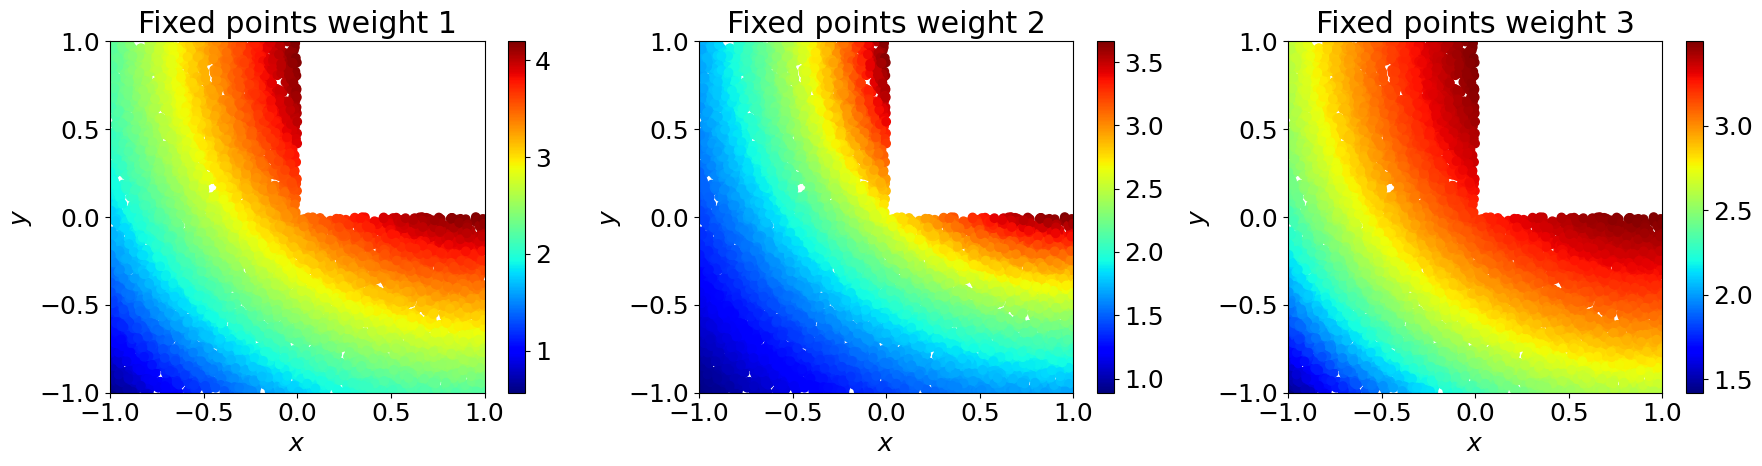

<Figure size 640x480 with 0 Axes>

In [9]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_res[:, 0], X_res[:, 1], c=fixed_w1[:, 0], cmap='jet')
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fixed points weight 1')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.scatter(X_res[:, 0], X_res[:, 1], c=fixed_w2[:, 0], cmap='jet')
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fixed points weight 2')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.scatter(X_res[:, 0], X_res[:, 1], c=fixed_w3[:, 0], cmap='jet')
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fixed points weight 3')
plt.tight_layout()

plt.show()
plt.savefig('weight_possion_Lshape.png', dpi=400)

## PINN模型

In [10]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True, 
                               retain_graph=True)

In [11]:
class PINNAC(nn.Module):
    def __init__(self, backbone, mu=None, sigma=None, points_weight_fn=None):
        super(PINNAC, self).__init__()
        self.backbone = backbone
        self.d = 0.0001
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False
            
        if points_weight_fn is not None:
            self.is_pw_fn = True
            self.pw_fn = points_weight_fn
        else:
            self.is_pw_fn = False
    
    def forward(self, X_res, X_bcs):
        if self.is_pw_fn:
            pw_res = self.pw_fn(X_res)
            pw_res.requires_grad_(False)
            loss_res = torch.mean(self.net_f(pw_res * X_res)**2)
        else:
            loss_res = torch.mean(self.net_f(X_res)**2)
        loss_bcs = torch.mean(self.net_u(X_bcs)**2)
        return loss_res, loss_bcs
    
    def net_u(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.backbone(X)
    
    def net_f(self, X_res):
        X_res.requires_grad_(True)
        u = self.net_u(X_res)

        grad_u = grad(u, X_res)[0]
        u_x = grad_u[:,[0]]
        u_y = grad_u[:,[1]]
        u_xx = grad(u_x, X_res)[0][:,[0]]
        u_yy = grad(u_y, X_res)[0][:,[1]]

        return 1 + u_xx + u_yy
    

pinn = PINNAC(backbone)

## Resample

In [12]:
# def prob_resample(dataset,Nsd, n_bcs, net_f,points_weight_fn ,num=500, eps=0.01):
#     X_resam, X_bcsam = dataset.train_data(Nsd, n_bcs)
#     X_resam = X_resam.float().to(device)
#     # 获得residule
#     f = net_f(X_resam)
#     f = f.detach().cpu().numpy()
#     # 计算概率权重
#     fixed_wn = points_weight_fn(X_resam).detach().cpu().numpy()
#     prob = np.concatenate([fixed_wn/fixed_wn.sum(), np.zeros(f.shape)], axis=1)
# #     prob = np.concatenate([np.log(abs(f / eps) + np.finfo(np.float32).eps), np.zeros(f.shape)], axis=1)
#     prob = np.max(prob, axis=1)
#     prob = prob / np.sum(prob)
#     # np.random.choice得到索引
#     idx = np.random.choice(X_resam.shape[0], num, replace=True, p=prob)
# #     print(fixed_wn/fixed_wn.sum().shape())
# #     print(X_resam[idx].shape)
#     return X_resam[idx].detach()

def prob_resample(X_resami, net_fi ,num=100, eps=0.01, plot=True):
    # 获得residule
    X_resami = X_resami.detach()
    fi = net_fi(X_resami)
    fi = fi.detach().cpu().numpy()
    # 计算概率权重
    prob = np.concatenate([np.log(abs(fi / eps) + np.finfo(np.float32).eps), np.zeros(fi.shape)], axis=1)
    prob = np.max(prob, axis=1)
    prob = prob / sum(prob)
    # np.random.choice得到索引
    idx = np.random.choice(X_resami.shape[0], num, replace=True, p=prob)
    return X_resami[idx].detach()

## Adam训练

In [13]:
# 训练
dataset = DatasetAC(domain)
X_res, X_bcs = dataset.train_data(Nsd, n_bcs)


mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(mlp_layers)
# 使用第一种权重生成方法
pinn = PINNAC(backbone, mu, sigma, points_weight_fn=points_weight_fn1).to(device)

optimizer_adam = optim.Adam(pinn.parameters(), lr=lr)
# lr_sche_step = int( adam_epoch / (np.log(1e-3) / np.log(lr_sche_gamma)) )
# print(f"ExponentialLR, gamma: {lr_sche_gamma}, step: {lr_sche_step}")
lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=gamma, verbose=True)

loss_r_log_adam = []
loss_b_log_adam = []
best_loss = 1e9

with open(train_info_path + 'train_info.txt', 'w') as f:
    f.write('Training by Adam:\n')
start_time = time.time()

for epoch in range(adam_epoch):
    pinn.zero_grad()
    
    loss_res, loss_bcs = pinn(X_res, X_bcs)
    loss = loss_res + 1000*loss_bcs
    
    loss.backward()
    optimizer_adam.step()
    
    loss_r_log_adam.append(loss_res.item())
    loss_b_log_adam.append(loss_bcs.item())
    
    if (epoch + 1) % 1000==0:
#         pinn.eval()
        # 重采样----------第一种方法----------
        X_resam1 = prob_resample(X_res, pinn.net_f)
#         X_resam2 = prob_resample(X_bcs, pinn.net_u)
        # 拼接数据
        print(X_resam1.shape)
#         print(X_resam2.shape)
        X_res = torch.cat([X_res, X_resam1], dim=0)
#         X_bcs = torch.cat([X_bcs, X_resam2], dim=0)
        print(X_res.shape)
#         pinn.train()
        
    if (epoch + 1) % 100 == 0:
        info = f'Epoch # {epoch+1:5d}/{adam_epoch}\ttime:{time.time()-start_time:.1e}\t' + \
            f'loss:{loss.item():.2e}, loss_r:{loss_res.item():.2e}, loss_b:{loss_bcs.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
        model_state = {'epoch': epoch+1, 'state_dict': pinn.backbone.state_dict()}
#         backbone_path = os.path.join(model_path, f'backbone_{epoch+1}.pth')
#         torch.save(model_state, backbone_path)
        if loss.item() < best_loss:
            # 保存训练loss最低的模型
            torch.save(model_state, os.path.join(model_path, f'backbone_adam.pth'))
            best_loss = loss.item()
            
    if ((epoch + 1)>5000) and ((epoch + 1)<=15000):
        if (epoch + 1 -5000) % step_size == 0:
            lr_sche.step()
#     if (epoch+1) % 1000 ==0:
#         X_res, X_bcs = dataset.train_data(Nsd, n_bcs)

forward with normalization, mu=[-0.16723540425300598, -0.17072656750679016], sigma=[0.555195689201355, 0.5518821477890015]
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch #   100/25000	time:1.8e+00	loss:1.48e+00, loss_r:1.43e+00, loss_b:4.31e-05
Epoch #   200/25000	time:3.0e+00	loss:1.08e+00, loss_r:1.06e+00, loss_b:1.81e-05
Epoch #   300/25000	time:4.2e+00	loss:9.40e-01, loss_r:9.26e-01, loss_b:1.44e-05
Epoch #   400/25000	time:5.5e+00	loss:8.55e-01, loss_r:8.43e-01, loss_b:1.27e-05
Epoch #   500/25000	time:6.7e+00	loss:7.92e-01, loss_r:7.80e-01, loss_b:1.21e-05
Epoch #   600/25000	time:7.9e+00	loss:7.41e-01, loss_r:7.29e-01, loss_b:1.23e-05
Epoch #   700/25000	time:9.2e+00	loss:6.97e-01, loss_r:6.84e-01, loss_b:1.28e-05
Epoch #   800/25000	time:1.0e+01	loss:6.57e-01, loss_r:6.44e-01, loss_b:1.32e-05
Epoch #   900/25000	time:1.2e+01	loss:6.21e-01, loss_r:6.07e-01, loss_b:1.34e-05
torch.Size([100, 2])
torch.Size([7556, 2])
Epoch #  1000/25000	time:1.3e+01	loss:5.87e-01, loss_r:

Epoch #  9300/25000	time:1.2e+02	loss:1.12e-02, loss_r:8.64e-03, loss_b:2.55e-06
Epoch #  9400/25000	time:1.2e+02	loss:1.10e-02, loss_r:8.48e-03, loss_b:2.53e-06
Epoch #  9500/25000	time:1.2e+02	loss:1.09e-02, loss_r:8.35e-03, loss_b:2.57e-06
Epoch #  9600/25000	time:1.3e+02	loss:1.07e-02, loss_r:8.17e-03, loss_b:2.49e-06
Epoch #  9700/25000	time:1.3e+02	loss:8.52e-02, loss_r:1.68e-02, loss_b:6.84e-05
Epoch #  9800/25000	time:1.3e+02	loss:1.31e-02, loss_r:8.09e-03, loss_b:4.97e-06
Epoch #  9900/25000	time:1.3e+02	loss:1.02e-02, loss_r:7.82e-03, loss_b:2.43e-06
torch.Size([100, 2])
torch.Size([8456, 2])
Epoch # 10000/25000	time:1.3e+02	loss:5.62e-02, loss_r:1.14e-02, loss_b:4.48e-05
Adjusting learning rate of group 0 to 1.6807e-04.
Epoch # 10100/25000	time:1.3e+02	loss:9.98e-03, loss_r:7.61e-03, loss_b:2.37e-06
Epoch # 10200/25000	time:1.3e+02	loss:9.85e-03, loss_r:7.49e-03, loss_b:2.36e-06
Epoch # 10300/25000	time:1.3e+02	loss:9.72e-03, loss_r:7.38e-03, loss_b:2.35e-06
Epoch # 10400/25

Epoch # 18600/25000	time:2.5e+02	loss:5.32e-03, loss_r:3.45e-03, loss_b:1.87e-06
Epoch # 18700/25000	time:2.5e+02	loss:5.84e-03, loss_r:3.45e-03, loss_b:2.39e-06
Epoch # 18800/25000	time:2.5e+02	loss:4.75e-03, loss_r:3.38e-03, loss_b:1.36e-06
Epoch # 18900/25000	time:2.5e+02	loss:4.71e-03, loss_r:3.36e-03, loss_b:1.35e-06
torch.Size([100, 2])
torch.Size([9356, 2])
Epoch # 19000/25000	time:2.5e+02	loss:4.67e-03, loss_r:3.34e-03, loss_b:1.33e-06
Epoch # 19100/25000	time:2.5e+02	loss:4.64e-03, loss_r:3.32e-03, loss_b:1.32e-06
Epoch # 19200/25000	time:2.5e+02	loss:4.70e-03, loss_r:3.29e-03, loss_b:1.40e-06
Epoch # 19300/25000	time:2.6e+02	loss:5.21e-03, loss_r:3.35e-03, loss_b:1.86e-06
Epoch # 19400/25000	time:2.6e+02	loss:4.99e-03, loss_r:3.29e-03, loss_b:1.71e-06
Epoch # 19500/25000	time:2.6e+02	loss:4.53e-03, loss_r:3.24e-03, loss_b:1.29e-06
Epoch # 19600/25000	time:2.6e+02	loss:6.15e-03, loss_r:3.32e-03, loss_b:2.82e-06
Epoch # 19700/25000	time:2.6e+02	loss:4.93e-03, loss_r:3.45e-03, l

In [14]:
mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(mlp_layers)
# 使用第一种权重生成方法
pinn = PINNAC(backbone, mu, sigma).to(device)

model_state = torch.load(os.path.join(model_path, 'backbone_adam.pth'))
pinn.backbone.load_state_dict(model_state['state_dict'])

optimizer_lbfgs = optim.LBFGS(pinn.backbone.parameters(), max_iter=newton_iter, line_search_fn="strong_wolfe",tolerance_grad=1.e-5,lr=0.8, tolerance_change=1.e-9)

loss_r_log_lbfgs = []
loss_b_log_lbfgs = []
it = 0
with open(train_info_path + 'train_info.txt', 'a') as f:
    f.write('Training by LBFGS:\n')


def closure():
    global it
    pinn.zero_grad()
    loss_res, loss_bcs = pinn(X_res, X_bcs)
    loss = loss_res + 1000*loss_bcs
    loss.backward()
    it = it + 1
    loss_r_log_lbfgs.append(loss_res.item())
    loss_b_log_lbfgs.append(loss_bcs.item())
    if (it + 1) % 100 == 0:
        info = f'Iter # {it + 1:4d}' +  f'loss:{loss.item():.2e}, loss_r:{loss_res.item():.2e}, loss_b:{loss_bcs.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
    
        
    return loss

for epoch in range(lbfgs_epoch):
    optimizer_lbfgs.step(closure)
    if loss.item() < best_loss:
        # 保存训练loss最低的模型
        torch.save(model_state, os.path.join(model_path, f'backbone_lbfgs.pth'))
        best_loss = loss.item()
    if (epoch+1) % 1000 ==0:
        X_res, X_bcs = dataset.train_data(Nsd, n_bcs)

forward with normalization, mu=[-0.149079829454422, -0.15500342845916748], sigma=[0.5530348420143127, 0.5502196550369263]
Iter #  100loss:3.23e-02, loss_r:1.93e-02, loss_b:1.30e-05
Iter #  200loss:1.72e-02, loss_r:8.05e-03, loss_b:9.18e-06
Iter #  300loss:1.10e-02, loss_r:4.42e-03, loss_b:6.58e-06
Iter #  400loss:8.56e-03, loss_r:3.07e-03, loss_b:5.49e-06
Iter #  500loss:6.97e-03, loss_r:2.53e-03, loss_b:4.43e-06
Iter #  600loss:5.64e-03, loss_r:1.96e-03, loss_b:3.68e-06
Iter #  700loss:4.73e-03, loss_r:1.42e-03, loss_b:3.32e-06
Iter #  800loss:3.95e-03, loss_r:1.09e-03, loss_b:2.86e-06
Iter #  900loss:3.12e-03, loss_r:9.97e-04, loss_b:2.13e-06
Iter # 1000loss:2.58e-03, loss_r:8.90e-04, loss_b:1.69e-06
Iter # 1100loss:2.19e-03, loss_r:8.02e-04, loss_b:1.39e-06
Iter # 1200loss:1.89e-03, loss_r:7.36e-04, loss_b:1.15e-06
Iter # 1300loss:1.66e-03, loss_r:6.86e-04, loss_b:9.74e-07
Iter # 1400loss:1.44e-03, loss_r:5.98e-04, loss_b:8.40e-07
Iter # 1500loss:1.17e-03, loss_r:4.89e-04, loss_b:6.

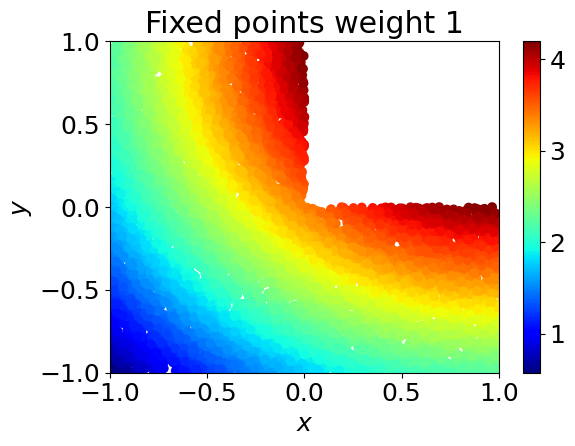

In [23]:
fixed_w1 = points_weight_fn1(X_res).cpu()
X_res = X_res.cpu()
plt.scatter(X_res[:, 0], X_res[:, 1], c=fixed_w1[:, 0], cmap='jet')
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fixed points weight 1')
plt.tight_layout()

## 结果可视化

In [16]:
plt.rcParams.update({'font.size':18})

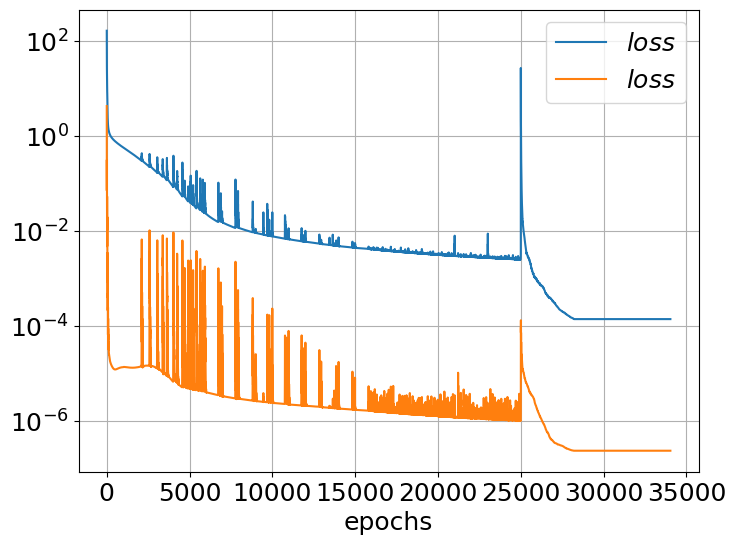

<Figure size 640x480 with 0 Axes>

In [17]:
plt.figure(figsize=(8, 6))
plt.subplot(111)
plt.plot(loss_r_log_adam+loss_r_log_lbfgs, label='$loss$')
plt.plot(loss_b_log_adam+loss_b_log_lbfgs, label='$loss$')
plt.xlabel('epochs')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('loss_log.png', dpi=100)
plt.show()
plt.savefig('loss_possion_Lshape.png', dpi=400)

(1, 109610)

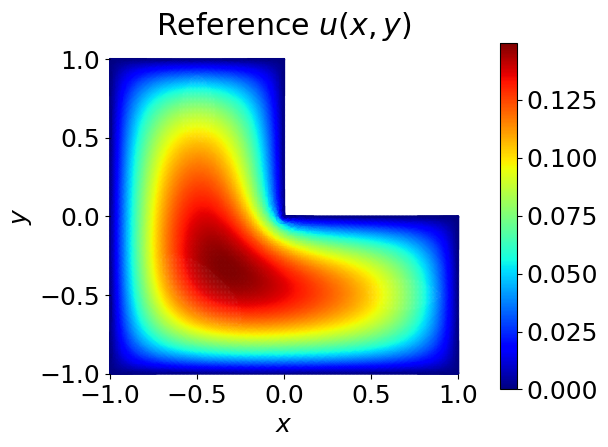

In [19]:
# load the data
data = scipy.io.loadmat('Lpoission_more.mat')

x = data['x']
y = data['y']
u_star = data['z']

ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('data', -1))
ax.spines['left'].set_position(('data', -1))
plt.scatter(x, y, c=u_star, s=1, marker='.', cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Reference $u(x,y)$')
plt.tight_layout()

# print(x.shape)
# xx, yy = np.meshgrid(x, y)
X = np.concatenate([x.reshape((-1, 1)), y.reshape((-1, 1))], axis=1)
u_star = u_star.reshape((1, -1))
X.shape
u_star.shape

In [20]:
pinn.eval()
# X = np.hstack((xx.reshape(-1,1), yy.reshape(-1,1)))
X = torch.from_numpy(X).double()

pinn.mu = pinn.mu.cpu().double()
pinn.sigma = pinn.sigma.cpu().double()
pinn = pinn.cpu().double()
u_pred = pinn.net_u(X).detach().numpy()
u_pred = u_pred.reshape(x.shape)

error = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star)
print('Relative l2 error: {:.3e}'.format(error))
u_pred.shape

Relative l2 error: 9.501e-03


(1, 109610)

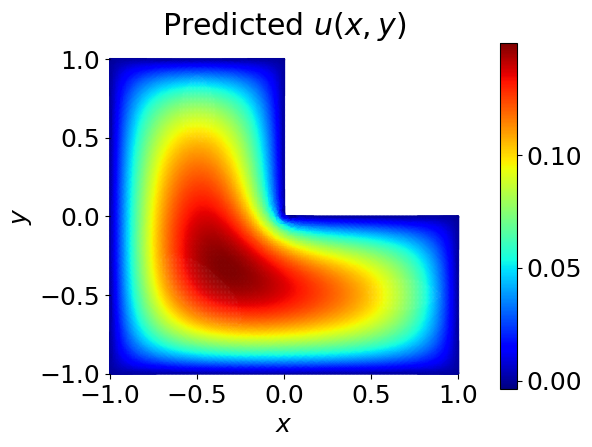

In [21]:
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('data', -1))
ax.spines['left'].set_position(('data', -1))
plt.scatter(x, y, c=u_pred, s=1, marker='.', cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Predicted $u(x,y)$')
plt.tight_layout()

/tmp/ipykernel_173695/3680345.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 3, 1)


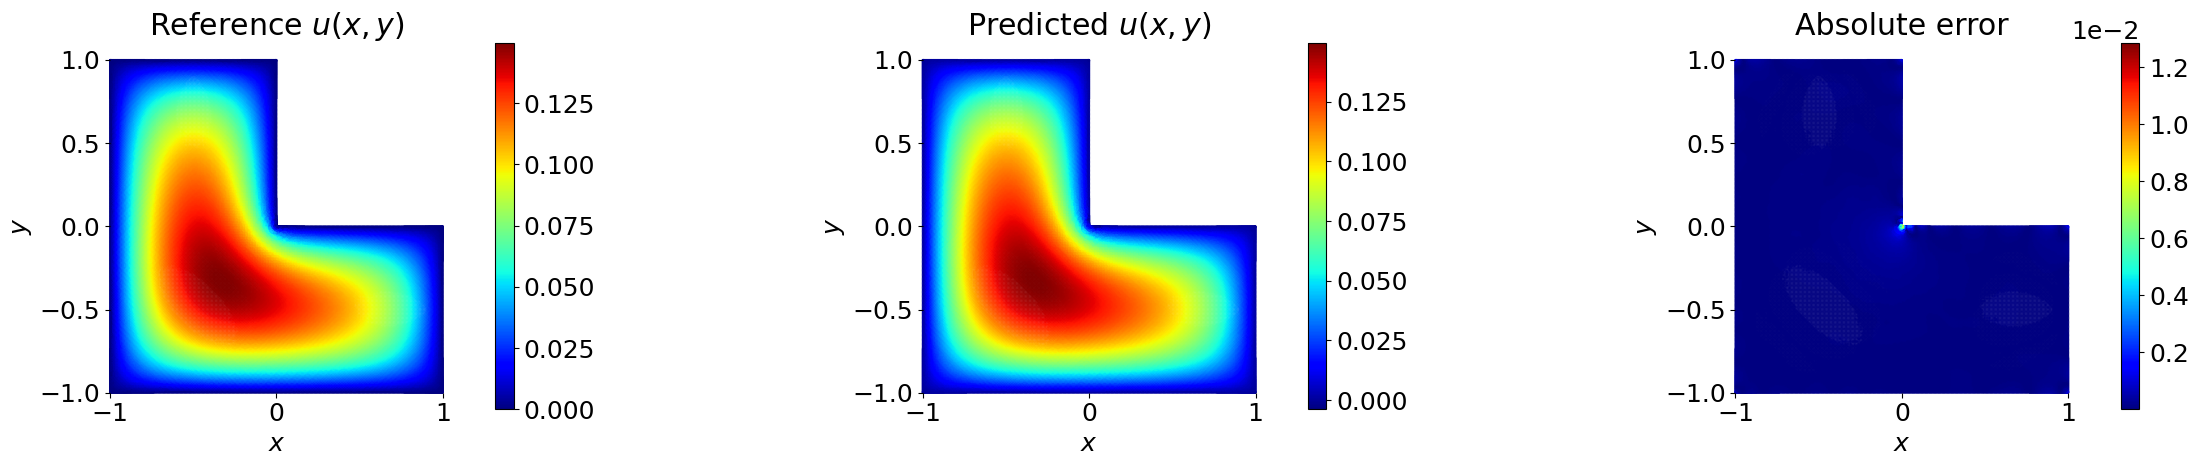

In [22]:
plt.rcParams.update({'font.size':18})

fig, ax = plt.subplots(3, figsize=(24, 5))

ax1 = plt.subplot(1, 3, 1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_position(('data', -1))
ax1.spines['left'].set_position(('data', -1))
plt.scatter(x, y, c=u_star, s=1, marker='.', cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Reference $u(x,y)$')
plt.tight_layout()
ax1.set_aspect(1./ax1.get_data_ratio())

ax2 = plt.subplot(1, 3, 2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_position(('data', -1))
ax2.spines['left'].set_position(('data', -1))
plt.scatter(x, y, c=u_pred, s=1, marker='.', cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Predicted $u(x,y)$')
plt.tight_layout()
ax2.set_aspect(1./ax2.get_data_ratio())

ax3 = plt.subplot(1, 3, 3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_position(('data', -1))
ax3.spines['left'].set_position(('data', -1))
plt.scatter(x, y, c=np.abs(u_star-u_pred), s=1, marker='.', cmap='jet')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0,0))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Absolute error')
plt.tight_layout()
ax3.set_aspect(1./ax3.get_data_ratio())
plt.savefig('result_possion_Lshape.png', dpi=400)